In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import dataset as dd # custom dataset class
import unet

# so that when you change an imported file, it changes in the notebook
%load_ext autoreload 
%autoreload 2
%matplotlib notebook

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

im_ref, im_us = dd.get_dataset(1)
X_train, y_train = (im_us,  im_ref)

im_ref_test, im_us_test = dd.get_dataset(1)
X_test, y_test = (im_us_test, im_ref_test)



In [2]:
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

('Training data shape: ', (320, 320, 256, 8))
('Training labels shape: ', (320, 320, 256, 1))
('Test data shape: ', (320, 320, 256, 8))
('Test labels shape: ', (320, 320, 256, 1))


In [6]:
from unetblocks import res_block

input_shape = X_train.shape[1:]
inputs = tf.keras.layers.Input(shape=input_shape)
res_out = res_block(inputs, resblocks=[res_block, res_block, res_block])
out = tf.keras.layers.Dense(1)(res_out)
model = tf.keras.models.Model(inputs=inputs, outputs=out)
## example from https://keras.io/callbacks/
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

Epoch 1/3
320/320 [==============================] - 41s 128ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 2/3
320/320 [==============================] - 41s 128ms/step - loss: 3.4075e-04 - mean_squared_error: 3.4071e-04
Epoch 3/3
320/320 [==============================] - 41s 128ms/step - loss: 1.9204e-04 - mean_squared_error: 1.9200e-04


In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 320, 256, 8)  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 320, 256, 16) 1168        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 160, 128, 16) 0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 160, 128, 16) 2320        max_pooling2d_7[0][0]            
__________________________________________________________________________________________________
max_poolin

In [8]:
model.fit(x=X_train, y=y_train, callbacks=[history], epochs=3)

NameError: name 'U' is not defined

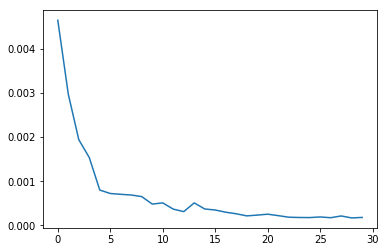

In [9]:
plt.plot(history.losses)
plt.show()

In [10]:
pred = model.predict(X_test)

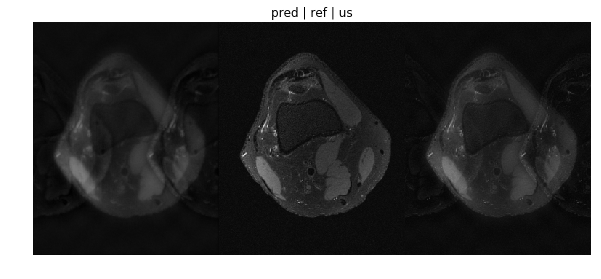

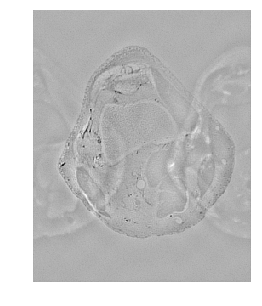

In [11]:
slice_to_show = 100

def sos(im, axis):
    return np.sqrt(np.sum(np.power(im, 2), axis=axis))

im1 = im_ref_test[slice_to_show, :, :, 0]
im2 = sos(im_us_test[slice_to_show, :, :, :], axis=2)
im3 = pred[slice_to_show, :, :, 0]


fig = plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((im3, im1, im2)), cmap='gray')
plt.title('pred | ref | us')
plt.axis('off')
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.imshow(im3 - im1, cmap='gray')
plt.axis('off')
plt.show()